In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

# Note: this example requires the torchmetrics library: https://torchmetrics.readthedocs.io
import torchmetrics
from tqdm import tqdm

import torchhd
from torchhd import embeddings
from torchhd.models import Centroid
from torchhd.datasets import EMGHandGestures

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

DIMENSIONS = 10000  # number of hypervector dimensions
NUM_LEVELS = 21
BATCH_SIZE = 1  # for GPUs with enough memory we can process multiple images at ones
WINDOW = 256
N_GRAM_SIZE = 4
DOWNSAMPLE = 5
SUBSAMPLES = torch.arange(0, WINDOW, int(WINDOW / DOWNSAMPLE))

Using cuda device


In [38]:
def transform(x):
    return x[SUBSAMPLES]


class Encoder(nn.Module):
    def __init__(self, out_features, timestamps, channels):
        super(Encoder, self).__init__()

        self.channels = embeddings.Random(channels, out_features)
        self.signals = embeddings.Level(NUM_LEVELS, out_features, high=20)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        signal = self.signals(input)
        samples = torchhd.bind(signal, self.channels.weight.unsqueeze(0))

        samples = torchhd.multiset(samples)
        sample_hv = torchhd.ngrams(samples, n=N_GRAM_SIZE)
        return torchhd.hard_quantize(sample_hv)

读取 data.mat文件，将其转化为csv文件

In [21]:
from scipy.io import loadmat

feature_struct = loadmat('../../data/EMG_based_hand_gesture/dataset.mat')

(dict, <function dict.keys>)

In [22]:
type(feature_struct), feature_struct.keys()

(dict,
 dict_keys(['__header__', '__version__', '__globals__', 'COMPLETE_1', 'LABEL_1', 'COMPLETE_3', 'LABEL_3', 'COMPLETE_4', 'LABEL_4', 'COMPLETE_5', 'LABEL_5', 'COMPLETE_2', 'LABEL_2']))

In [33]:
for key in feature_struct:
    print(f"{key} shape: {len(feature_struct[key])}")
feature_struct['LABEL_1'], feature_struct['COMPLETE_1']

__header__ shape: 76
__version__ shape: 3
__globals__ shape: 0
COMPLETE_1 shape: 148831
LABEL_1 shape: 148831
COMPLETE_3 shape: 137573
LABEL_3 shape: 137573
COMPLETE_4 shape: 134335
LABEL_4 shape: 134335
COMPLETE_5 shape: 98130
LABEL_5 shape: 98130
COMPLETE_2 shape: 139135
LABEL_2 shape: 139135


(array([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.40625000e-03, 9.62500000e-04, 3.43750000e-04, 1.43750000e-04],
        [1.93871875e-02, 1.92162500e-03, 7.27812500e-04, 2.98562500e-04],
        ...,
        [3.07244698e-01, 3.79497131e-02, 2.47896621e-02, 1.42866644e-02],
        [3.08178501e-01, 3.78952160e-02, 2.47667655e-02, 1.43125477e-02],
        [3.09127966e-01, 3.79037638e-02, 2.48128478e-02, 1.43006723e-02]]))

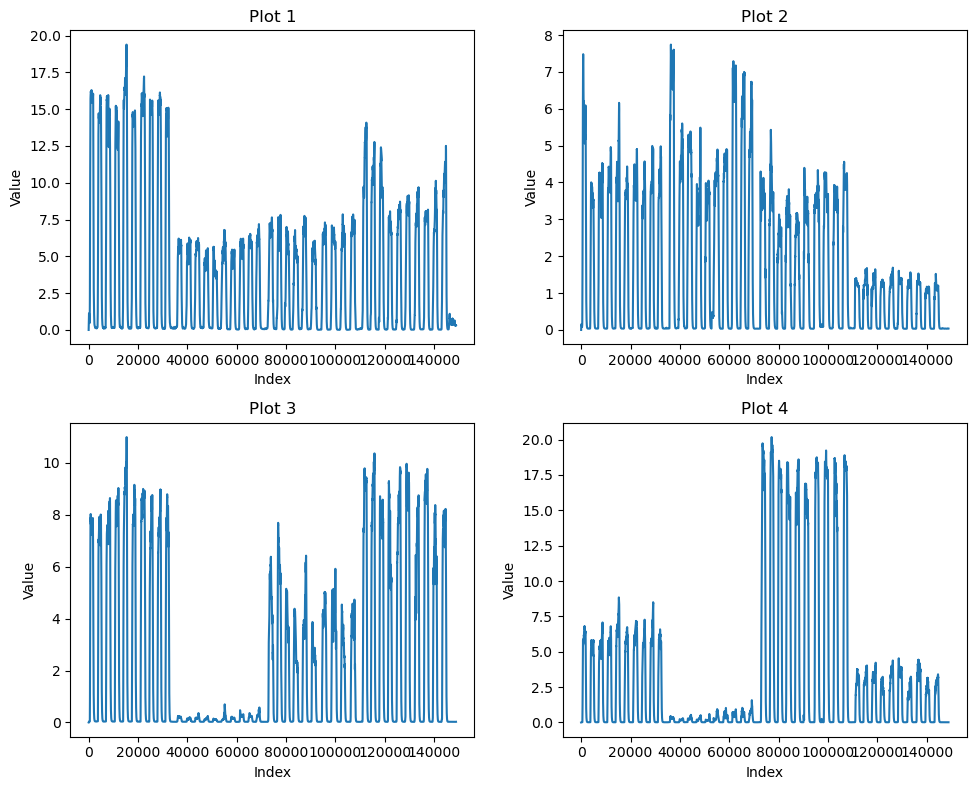

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# 假设你的数组如下所示
data = feature_struct['COMPLETE_1']

# 创建一个图形窗口
plt.figure(figsize=(10, 8))  # 可以指定图形的大小

# 绘制四个子图
for i in range(4):
    plt.subplot(2, 2, i+1)  # 参数表示(行数, 列数, 子图编号)
    plt.plot(data[:, i])  # 绘制第i列的数据
    plt.title(f'Plot {i+1}')  # 为每个子图设置标题
    plt.xlabel('Index')  # x轴标签
    plt.ylabel('Value')  # y轴标签

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

In [35]:
import pandas as pd
from scipy.io import loadmat

# 加载.mat文件
mat_data = loadmat('../../data/EMG_based_hand_gesture/dataset.mat')

# 遍历.mat文件中的所有变量
for key in mat_data:
    # 跳过MATLAB的系统变量
    if key.startswith("__"):
        continue
    
    # 提取数据
    data = mat_data[key]
    
    # 确保数据是二维的，因为CSV是二维表格
    if data.ndim == 2:
        # 将数据转换为DataFrame
        df = pd.DataFrame(data)
        
        # 保存为CSV文件，文件名与变量名相同
        csv_filename = f'{key}.csv'
        df.to_csv(csv_filename, index=False)
        print(f'Saved {key} to {csv_filename}')
    else:
        print(f'Skipping {key} because it is not two-dimensional.')

Saved COMPLETE_1 to COMPLETE_1.csv
Saved LABEL_1 to LABEL_1.csv
Saved COMPLETE_3 to COMPLETE_3.csv
Saved LABEL_3 to LABEL_3.csv
Saved COMPLETE_4 to COMPLETE_4.csv
Saved LABEL_4 to LABEL_4.csv
Saved COMPLETE_5 to COMPLETE_5.csv
Saved LABEL_5 to LABEL_5.csv
Saved COMPLETE_2 to COMPLETE_2.csv
Saved LABEL_2 to LABEL_2.csv


In [12]:
def experiment(subjects=[0]):
    print("List of subjects " + str(subjects))
    ds = EMGHandGestures(
        "../../data", download=True, subjects=subjects, transform=transform
    )

    train_size = int(len(ds) * 0.7)
    test_size = len(ds) - train_size
    train_ds, test_ds = data.random_split(ds, [train_size, test_size])

    train_ld = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_ld = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    encode = Encoder(DIMENSIONS, ds[0][0].size(-2), ds[0][0].size(-1))
    encode = encode.to(device)

    num_classes = len(ds.classes)
    model = Centroid(DIMENSIONS, num_classes)
    model = model.to(device)

    with torch.no_grad():
        for samples, targets in tqdm(train_ld, desc="Training"):
            samples = samples.to(device)
            targets = targets.to(device)

            sample_hv = encode(samples)
            model.add(sample_hv, targets)

    accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_classes)

    with torch.no_grad():
        model.normalize()

        for samples, targets in tqdm(test_ld, desc="Testing"):
            samples = samples.to(device)

            sample_hv = encode(samples)
            output = model(sample_hv, dot=True)
            accuracy.update(output.cpu(), targets)

    print(f"Testing accuracy of {(accuracy.compute().item() * 100):.3f}%")

In [39]:
# Make a model for each subject
for i in range(5):
    experiment([i])

List of subjects [0]
Files already downloaded and verified


Training:   0%|          | 0/368 [00:00<?, ?it/s]/tmp/ipykernel_13799/972268109.py:18: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)
Testing: 100%|██████████| 158/158 [00:00<00:00, 298.73it/s]


Testing accuracy of 100.000%
List of subjects [1]
Files already downloaded and verified


Training:   0%|          | 0/345 [00:00<?, ?it/s]/tmp/ipykernel_13799/972268109.py:18: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)
Testing: 100%|██████████| 148/148 [00:00<00:00, 462.40it/s]


Testing accuracy of 95.270%
List of subjects [2]
Files already downloaded and verified


Training:   0%|          | 0/338 [00:00<?, ?it/s]/tmp/ipykernel_13799/972268109.py:18: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)
Testing: 100%|██████████| 145/145 [00:00<00:00, 469.00it/s]


Testing accuracy of 98.621%
List of subjects [3]
Files already downloaded and verified


Training:   0%|          | 0/333 [00:00<?, ?it/s]/tmp/ipykernel_13799/972268109.py:18: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)
Testing: 100%|██████████| 143/143 [00:00<00:00, 183.22it/s]


Testing accuracy of 95.804%
List of subjects [4]
Files already downloaded and verified


Training:   0%|          | 0/235 [00:00<?, ?it/s]/tmp/ipykernel_13799/972268109.py:18: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)
Testing: 100%|██████████| 101/101 [00:00<00:00, 181.69it/s]

Testing accuracy of 98.020%
